In [ ]:
# # installs
# ! pip install swig
# ! pip install gym
# ! pip install box2d-py
# ! pip install torchvision

In [1]:
# imports
import torchvision
import numpy as np
import gym
import torch
import torch.nn as nn
import torch.functional as F
from matplotlib import pyplot as plt
from IPython import display
from matplotlib import style
plt.style.use("ggplot")
# TODO; you'll need to import something for the t-test

In [2]:
# get data from GDrive
# from google.colab import drive
# drive.mount('/content/drive')

# you may get a pop-up asking "Permit this notebook to access your Google Drive files?"
# click yes through the prompts
# if you know how to save this setting, please let me know.

# these end up in /content
! gdown --id 1BX-hkRChkcwX62A8nS5oCeE2g1H7b3D5 # states_expert_Pendulum
! gdown --id 1rlkHmX7Io06fe2rMakBqWVRfwB4vZ5D_ # actions_expert_Pendulum
! gdown --id 1dFkflncoC2A18rZQJlXKB34YvADRRaBt # rewards expert
! gdown --id 1XeVxXSvBW8fQCV1HyIehvvuIMIjZTG45 # rewards random

/home/raka/Projects/BehaviorCloningAssignment/.venv/lib/python3.10/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1BX-hkRChkcwX62A8nS5oCeE2g1H7b3D5
To: /home/raka/Projects/BehaviorCloningAssignment/states_expert_Pendulum.npy
100%|██████████████████████████████████████| 2.40M/2.40M [00:00<00:00, 9.32MB/s]
/home/raka/Projects/BehaviorCloningAssignment/.venv/lib/python3.10/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1rlkHmX7Io06fe2rMakBqWVRfwB4vZ5D_
To: /home/raka/Projects/BehaviorCloningAssignment/actions_expert_Pendulum.npy
100%|████████████████████████████████████████| 800k/800k [00:00<00:0

In [20]:
# constants, parameters

# BC data param's
NUM_HUMAN_PTS = 25 # number of episodes
NUM_HUMAN_PTS2 = -1 # number of time points
# if this is <0, NUM_HUMAN_PTS2 is not used, should be 199*NUM_HUMAN_PTS

#NUM_HUMAN_PTS = 25 # number of episodes
#NUM_HUMAN_PTS2 = 5 # number of time points

# NN param's
NUM_TR_EPOCHS = 25
BATCH_SIZE = 256
LR = 0.003
LOSS_FUNC = nn.MSELoss()
# things tried:
# NUM_TR_EPOCHS = 300 # overfits
# LOSS_FUNC = nn.L1Loss() # doesn't help
# LR = .001 # gets it so that BC reward > Expert reward !
# NUM_HUMAN_PTS = 100 # gets it so that BC reward > Expert reward !

N_PLOT_ACTION = 250 # for 3D viz.

NUM_ITERATIONS = 25
N_PLOT_EPISODES = 25
# things tried
# NUM_ITERATIONS = 6
# N_PLOT_EPISODES = 50

# saving
LOSS_PLOT_PREFIX_FNAME = 'loss_plot'
COMPARISON_PLOT_PREFIX_FNAME = 'compare_plot'

In [ ]:
# constants, parameters

# BC data param's
NUM_HUMAN_PTS = 25 # number of episodes
NUM_HUMAN_PTS2 = -1 # number of time points
# if this is <0, NUM_HUMAN_PTS2 is not used, should be 199*NUM_HUMAN_PTS

#NUM_HUMAN_PTS = 25 # number of episodes
#NUM_HUMAN_PTS2 = 5 # number of time points

# NN param's
NUM_TR_EPOCHS = 25
BATCH_SIZE = 256
LR = 0.003
LOSS_FUNC = nn.MSELoss()
# things tried:
# NUM_TR_EPOCHS = 300 # overfits
# LOSS_FUNC = nn.L1Loss() # doesn't help
# LR = .001 # gets it so that BC reward > Expert reward !
# NUM_HUMAN_PTS = 100 # gets it so that BC reward > Expert reward !

N_PLOT_ACTION = 250 # for 3D viz.

NUM_ITERATIONS = 25
N_PLOT_EPISODES = 25
# things tried
# NUM_ITERATIONS = 6
# N_PLOT_EPISODES = 50

# saving
LOSS_PLOT_PREFIX_FNAME = 'loss_plot'
COMPARISON_PLOT_PREFIX_FNAME = 'compare_plot'

In [21]:
# init environment
env_name = "Pendulum-v1"
env = gym.make(env_name)
action_space_size = env.action_space.shape[0]
state_space_size  = env.observation_space.shape[0]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device", device)

device cpu


In [22]:
# Load Expert data (states and actions for BC, States only for BCO)
expert_states  = torch.tensor(np.load("states_expert_Pendulum.npy"), dtype=torch.float)
expert_actions = torch.tensor(np.load("actions_expert_Pendulum.npy"), dtype=torch.float)
print("expert_states shape", expert_states.shape)
print("expert_actions shape", expert_actions.shape)
# these are episode x time x dimensionality
print( "state_space_size", state_space_size) # 3
print( "action_space_size", action_space_size) # 1

# tracing, first 5
ep=1
print( "expert_states", expert_states[ep, 0:5, :] )
print( "expert_actions", expert_actions[ep, 0:5, :] )

# tracing, first 5 w/ neg. x
count = 0
for i in range(expert_states.shape[0]):
    for j in range(expert_states.shape[1]):
        if (expert_states[i,j,0] < 0):
            print( f"{i} {j} {expert_states[i,j,:]}")
            print( f"{i} {j} {expert_actions[i,j,:]}")
            count += 1
            if ( count >= 5 ):
                break
    if ( count >= 5 ):
        break

expert_states shape torch.Size([500, 200, 3])
expert_actions shape torch.Size([500, 200, 1])
state_space_size 3
action_space_size 1
expert_states tensor([[0.8381, 0.5455, 0.9793],
        [0.7965, 0.6047, 1.4486],
        [0.7267, 0.6869, 2.1569],
        [0.6201, 0.7845, 2.8939],
        [0.4667, 0.8844, 3.6656]])
expert_actions tensor([[0.4013],
        [1.6985],
        [1.4789],
        [1.2222],
        [1.5421]])
0 4 tensor([-0.1261, -0.9920, -3.2372])
0 4 tensor([-2.])
0 5 tensor([-0.3339, -0.9426, -4.2812])
0 5 tensor([-2.])
0 6 tensor([-0.5687, -0.8226, -5.2882])
0 6 tensor([-2.])
0 7 tensor([-0.7927, -0.6097, -6.2051])
0 7 tensor([-2.])
0 8 tensor([-0.9531, -0.3027, -6.9624])
0 8 tensor([-2.])


In [32]:
def to_input (states, actions,  n=2, compare=1):
    '''
    Data preperpation and filtering
    Inputs:
    states: expert states as tensor
    actions: actions states as tensor
    n: window size (how many states needed to predict the next action)
    compare: for filtering data
    return:
    output_states: filtered states as tensor
    output_actions: filtered actions as tensor
    '''
    count=0
    index= []
    ep, t, state_size = states.shape
    _, _, action_size = actions.shape

    output_states = torch.zeros((ep*(t-n+1) , state_size*n), dtype = torch.float) # 500*(200-2+1) = 500*199 = 99500; 99500x(3*2)=99500x6
    output_actions = torch.zeros((ep*(t-n+1) , action_size), dtype = torch.float) # 99500x1

    for i in range (ep): # episode
        for j in range (t-n+1): # time
            if (states[i, j] == -compare*torch.ones(state_size)).all() or (states[i, j+1] == -compare*torch.ones(state_size)).all(): # drop bad values
                index.append([i,j])
            else:
                output_states[count] = states[i, j:j+n].view(-1)
                output_actions[count] = actions[i,j]
                count+=1
    output_states= output_states[:count]
    output_actions= output_actions[:count]

    return output_states, output_actions, index

In [33]:
# selecting number expert trajectories from expert data
number_expert_trajectories = NUM_HUMAN_PTS
#a= np.random.randint(expert_states.shape[0] - number_expert_trajectories) # this would be good but causes variablity in student submissions
a = 0
print(a)
expert_state, expert_action, index = to_input (expert_states[a : a+number_expert_trajectories], expert_actions[a : a+number_expert_trajectories], n=2,  compare=5)
if ( NUM_HUMAN_PTS2 > 0 ): # crop by time steps
  expert_state = expert_state[:NUM_HUMAN_PTS2, :]
  expert_action = expert_action[:NUM_HUMAN_PTS2, :]
print("expert_state", expert_state.shape)
print("expert_action", expert_action.shape)
print(f"Bad data size: {len(index)}")

0
expert_state torch.Size([4975, 6])
expert_action torch.Size([4975, 1])
Bad data size: 0


In [25]:
# concatenate expert states and actions, divided into 70% training and 30% testing
new_data = np.concatenate((expert_state[:,: state_space_size], expert_action), axis=1)
np.random.shuffle(new_data)
new_data = torch.tensor(new_data, dtype=torch.float)
n_samples = int(new_data.shape[0]*0.7)
training_set = new_data[:n_samples]
testing_set = new_data[n_samples:]
print("training_set", training_set.shape)
print("testing_set", testing_set.shape)

training_set torch.Size([3482, 4])
testing_set torch.Size([1493, 4])


In [26]:
bc_pendulum = nn.Sequential(
    nn.Linear(state_space_size,40),
    nn.Linear(40,action_space_size))
# TODO; fill in your neural network
criterion = LOSS_FUNC
learning_rate = LR
optimizer = torch.optim.Adam(bc_pendulum.parameters(), lr = learning_rate)

In [36]:
# train the neural network

# 200 epochs ~ 1 minute
loss_list = []
test_loss = []
batch_size = BATCH_SIZE
n_epoch = NUM_TR_EPOCHS
optimizer = torch.optim.Adam(bc_pendulum.parameters(), lr = learning_rate)
for itr in range(n_epoch):
    total_loss = 0
    b=0
    for batch in range (0,training_set.shape[0], batch_size):
        data   = training_set  [batch : batch+batch_size , :state_space_size]
        y      = training_set [batch : batch+batch_size, state_space_size:]
        y_pred = bc_pendulum(data)
        loss   = criterion(y_pred, y)
        total_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        b += 1
    print("[EPOCH]: %i, [MSE LOSS]: %.6f" % (itr+1, total_loss / b))
    # display.clear_output(wait=True)
    loss_list.append(total_loss / b)
    x = testing_set[:, :state_space_size]
    y = testing_set[:,state_space_size:]
    y_pred = bc_pendulum(x)
    test_loss.append(criterion(y_pred, y).item())

[EPOCH]: 1, [MSE LOSS]: 1.939981
[EPOCH]: 2, [MSE LOSS]: 1.948529
[EPOCH]: 3, [MSE LOSS]: 1.937986
[EPOCH]: 4, [MSE LOSS]: 1.936290
[EPOCH]: 5, [MSE LOSS]: 1.938715
[EPOCH]: 6, [MSE LOSS]: 1.937161
[EPOCH]: 7, [MSE LOSS]: 1.937708
[EPOCH]: 8, [MSE LOSS]: 1.937767
[EPOCH]: 9, [MSE LOSS]: 1.937631
[EPOCH]: 10, [MSE LOSS]: 1.937726
[EPOCH]: 11, [MSE LOSS]: 1.937694
[EPOCH]: 12, [MSE LOSS]: 1.937681
[EPOCH]: 13, [MSE LOSS]: 1.937676
[EPOCH]: 14, [MSE LOSS]: 1.937655
[EPOCH]: 15, [MSE LOSS]: 1.937637
[EPOCH]: 16, [MSE LOSS]: 1.937617
[EPOCH]: 17, [MSE LOSS]: 1.937596
[EPOCH]: 18, [MSE LOSS]: 1.937574
[EPOCH]: 19, [MSE LOSS]: 1.937550
[EPOCH]: 20, [MSE LOSS]: 1.937526
[EPOCH]: 21, [MSE LOSS]: 1.937502
[EPOCH]: 22, [MSE LOSS]: 1.937478
[EPOCH]: 23, [MSE LOSS]: 1.937453
[EPOCH]: 24, [MSE LOSS]: 1.937428
[EPOCH]: 25, [MSE LOSS]: 1.937402


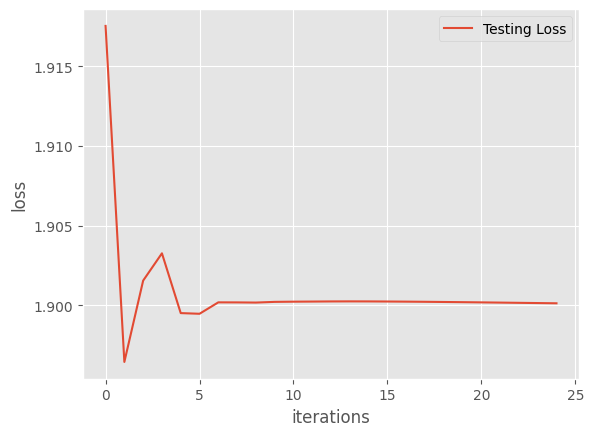

In [28]:
# plot test loss
# torch.save(bc_pendulum, "bc_pendulum_n=2") # uncomment to save the model
plt.plot(test_loss, label="Testing Loss")
plt.xlabel("iterations")
plt.ylabel("loss")
plt.legend()

# have to save before showing
plt.ioff()
plt.savefig(f'{LOSS_PLOT_PREFIX_FNAME}_lr{LR}.png')
plt.ion()

plt.show()

In [29]:
def plot_pendulum( ax, state, action, color="red" ):
    # Create a 3D figure
    # Plot the vector
    x = state[0]; y = state[1]; z = action
    #ax.quiver(0, 0, 0, x, y, z, color=color) # plot a vector
    ax.scatter(x,y,z,color=color)

    # Set labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Action')

    # Show the plot
    return ax

torch.Size([1493, 3])


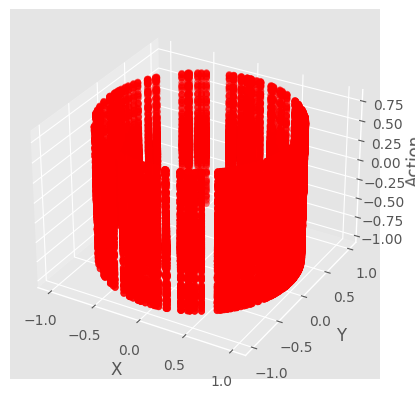

In [38]:
# 3D viz; check the fit of the neural network to expert data

x = testing_set[:, :state_space_size] # here x is the training data's state space, not the x dimension in the environment
# y is defined above, it's the training data's action, not the y dimension in the environment
print( x.shape ) # torch.Size([2985, 3])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax = plot_pendulum( ax, [x[:N_PLOT_ACTION,0].detach().numpy(), x[:N_PLOT_ACTION,1].detach().numpy()], y[:N_PLOT_ACTION].detach().numpy(), color='blue')
ax = plot_pendulum( ax, [x[:N_PLOT_ACTION,0].detach().numpy(), x[:N_PLOT_ACTION,1].detach().numpy()], y_pred[:N_PLOT_ACTION].detach().numpy(), color='red')
plt.show()

In [31]:
# try it in the gym

# 1000 takes > 3 minutes
# 250 takes ~1 minute
################################## parameters ##################################
n=2 # window size
n_iterations = NUM_ITERATIONS # max number of interacting with environment
n_ep = N_PLOT_EPISODES # number of episodes
max_steps = 500 # max timesteps per episode
gamma = 1.0 # discount factor
seeds = [684, 559, 629, 192, 835] # random seeds for testing
seeds = np.random.randint(-10000, 10000, size=NUM_ITERATIONS)
################################## parameters ##################################

seed_reward_mean = []
seed_reward  = []
for itr in range (n_iterations):
   ################################## interact with env ##################################
    G= []
    G_mean = []
    #env.seed(int(seeds[itr]))
    torch.manual_seed(int(seeds[itr]))
    torch.cuda.manual_seed_all(int(seeds[itr]))

    for ep in range (n_ep):
        state = env.reset() # old syntax
        #state = state[0] # new syntax, this is a tuple so just get the 1st thing
        if ( ep == 0 ):
            print( f"state {state}" )
        rewards = []
        R=0
        for t in range (max_steps):
            action = bc_pendulum(torch.tensor(state, dtype=torch.float))
            if ( ep == 0 ):
                print( f"action {action}" )
            action = np.clip(action.detach().numpy(), -2,2)
            next_state , r, done, info   = env.step(action) # old syntax
            #next_state, r, done, truncated, info  = env.step(action) # new syntax
            if ( ep == 0 ):
                print( f"next state {next_state}" )
                #input()
            rewards.append(r)
            state = next_state
            if done:
                break
        R = sum([rewards[i]*gamma**i for i in range (len(rewards))])
        G.append(R)
        G_mean.append(np.mean(G))
        if ep % 1 ==0:
            print("ep = {} , Mean Reward = {:.6f}".format(ep, R))
        # display.clear_output(wait=True)
    seed_reward.append(G)
    seed_reward_mean.append(G_mean)
    print("Itr = {} overall reward  = {:.6f} ".format(itr, np.mean(seed_reward_mean[-1])))
    print("Interacting with environment finished")
env.close()
#np.save("reward_mean_pendulum_bc_expert_states={},run={}".format(new_data.shape[0]), seed_reward_mean) #uncomment to save reward over 5 random seeds

state (array([-0.92107004,  0.38939688, -0.37721986], dtype=float32), {})


/tmp/ipykernel_9756/934824431.py:33: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  action = bc_pendulum(torch.tensor(state, dtype=torch.float))


ValueError: expected sequence of length 3 at dim 1 (got 0)

In [ ]:
# BC stats
seed_reward_mean_bc = np.array(seed_reward_mean)
mean_bc  = np.mean(seed_reward_mean_bc,axis=0)
std_bc  = np.std(seed_reward_mean_bc,axis=0)

In [ ]:
# expert
expert  = np.load("/content/reward_mean_pendulum_expert.npy")
mean_expert= np.mean(expert,axis=0)
std_expert = np.std(expert,axis=0)

# subset to same length as sim. above
mean_expert = mean_expert[:N_PLOT_EPISODES]
std_expert = std_expert[:N_PLOT_EPISODES]

In [ ]:
# random
random_mean  = np.load("/content/reward_mean_pendulum_random.npy")
mean_random= np.mean(random_mean,axis=0)
std_random  = np.std(random_mean,axis=0)

# subset to same length as sim. above
mean_random = mean_random[:N_PLOT_EPISODES]
std_random = std_random[:N_PLOT_EPISODES]

end expert, BC, random: -724.0260578336769, -1303.8650963094553, -1212.868791051409
T-statistic: 2
P-value: 1
T-statistic: 3
P-value: 2


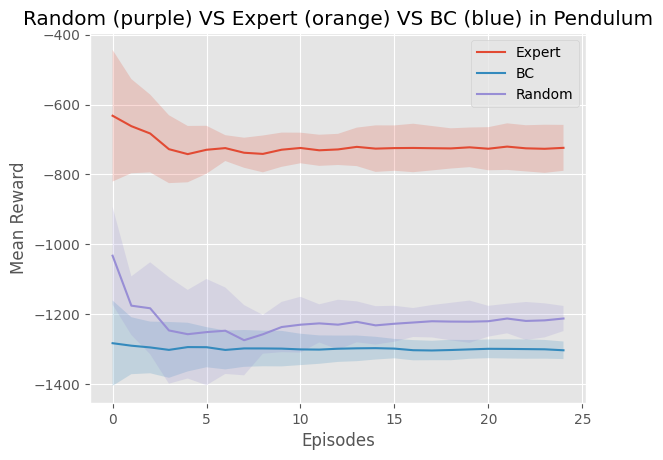

In [ ]:
# compare the 3 modes
x = np.arange(N_PLOT_EPISODES)

plt.plot(x, mean_expert, "-", label="Expert")
plt.fill_between(x, mean_expert+std_expert, mean_expert-std_expert, alpha=0.2)

plt.plot(x, mean_bc, "-", label="BC")
plt.fill_between(x, mean_bc + std_bc, mean_bc - std_bc, alpha=0.2)

plt.plot(x, mean_random, "-", label="Random")
plt.fill_between(x, mean_random+std_random, mean_random-std_random, alpha=0.2)

plt.xlabel("Episodes")
plt.ylabel("Mean Reward")
plt.title("Random (purple) VS Expert (orange) VS BC (blue) in Pendulum")
plt.legend()


print( f"end expert, BC, random: {mean_expert[-1]}, {mean_bc[-1]}, {mean_random[-1]}" )

# t-test b/t expert and BC
t_stat, p_value = 2, 1 # TODO update
print("T-statistic:", t_stat)
print("P-value:", p_value)

# t-test b/t BC and random
t_stat, p_value = 3, 2 # TODO update
print("T-statistic:", t_stat)
print("P-value:", p_value)